In [117]:
# load-in libraries
import nltk
import requests
import re
from sklearn.feature_extraction.text import TfidfVectorizer
# nltk.download('stopwords')

### Introduction
We'll look at text samples from the plays of William Shakespeare and Ben Jonson, a contemporary of Shakespeare, to see if we can train a model which can accurately determine who the author of a given piece of text is. To do this, we must first pull-in our source data from Project Gutenberg and vectorize the texts. Here, we will consider the individual lines as the observations in order to build a larger dataset and not, then, get to predict on an entire play. This sparsity of data will likely inflate our error more than if we had an entire play, or even act, to identify.

In [118]:
# we'll look at the comedies of each (4 a piece)
source_dict = {'Every Man in his Humour': 'http://www.gutenberg.org/cache/epub/3694/pg3694.txt', 
               'Volpone' : 'http://www.gutenberg.org/cache/epub/4039/pg4039.txt', 
               'The Alchemist': 'http://www.gutenberg.org/cache/epub/4081/pg4081.txt',
               'Bartholomew Fair' : 'http://www.gutenberg.org/cache/epub/49461/pg49461.txt',
               'As You Like It' : 'http://www.gutenberg.org/cache/epub/1121/pg1121.txt', 
                'The Comedy of Errors' : 'https://www.gutenberg.org/files/23046/23046-0.txt', 
                'Twelfth Night' : 'http://www.gutenberg.org/cache/epub/1123/pg1123.txt',
                'Tempest' : 'http://www.gutenberg.org/cache/epub/1135/pg1135.txt'}
author_dict = {'As You Like It': 'Shakespeare', 'The Comedy of Errors':'Shakespeare','Twelfth Night':'Shakespeare',
              'Tempest':'Shakespeare', 'Every Man in his Humour':'Jonson','Volpone':'Jonson', 
               'The Alchemist':'Jonson', 'Bartholomew Fair':'Jonson'}
author_map = {'Jonson' : 0, 'Shakespeare' : 1}

In [119]:
def prepare_text(url_dict, line_size = 12):
    data_dict = {'play' : [], 'raw_text' : [], 'author' : []}
    tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
    texts, plays = [], []
    for title, url in url_dict.items():
        r = requests.get(url)
        r.encoding = 'utf-8'
        html = r.text[55000:-20000]  # make sure to remove header & footer w/ licenses & other non-text stuff
        lines = re.split('\n\r|\r\n', html)
        for i in range(len(lines)):
            if len(lines[i]) > line_size:  # remove shorter lines (likely names or stage directions)
                line_tokenized = tokenizer.tokenize(lines[i].lower())
                data_dict['raw_text'].append(' '.join(w for w in line_tokenized))
                data_dict['play'].append(title)
                data_dict['author'].append(author_dict[title])
    return data_dict

In [120]:
text_dict = prepare_text(source_dict, line_size = 50)

In [121]:
# setup our pandas dataframe containing the lines and textual information
import pandas as pd
df = pd.DataFrame(text_dict)
df['label'] = df['author'].map(author_map)
df.head(10)

,play,raw_text,author,label
0,Every Man in his Humour,lor se now trust me here s a goodly day toward,Jonson,0
1,Every Man in his Humour,musco call up my son lorenzo bid him rise tell...,Jonson,0
2,Every Man in his Humour,the sovereign use of study what cousin stephano,Jonson,0
3,Every Man in his Humour,step nothing but e en come to see how you do u...,Jonson,0
4,Every Man in his Humour,lor se that s kindly done you are welcome cousin,Jonson,0
5,Every Man in his Humour,step ay i know that sir i would not have come ...,Jonson,0
6,Every Man in his Humour,lor se oh well well go in and see i doubt he s...,Jonson,0
7,Every Man in his Humour,step uncle afore i go in can you tell me an he...,Jonson,0
8,Every Man in his Humour,of the sciences of hawking and hunting i would...,Jonson,0
9,Every Man in his Humour,lor se why i hope you will not a hawking now w...,Jonson,0


### Vectorizing text
In order to pass-in our lines to a classification model, we need to transform our raw text into numeric vectors. We'll use tf-idf vectorizing which intends to predict the importance of a particular word in a corpus of text. Roughly, the statistic increases by the instances of a particular word and is depressed if that word is present in a large number of lines in the corpus (thus deflating the importance of common words like 'the'). The vector returned is then something we can directly feed into our classification model.

In [123]:
# need to vectorize texts in order to fit our classification model
vectorizer = TfidfVectorizer()
corpus = []
for line in df.raw_text:
    corpus.append(line)
model = vectorizer.fit(corpus)

Now that our text is vectorized, we will be using Logistic Regression to classify lines of text as being written by Ben Jonson or William Shakespeare. The model will learn a weight vector $\vec{w}$ from our input train set of lines and their respective labels. Then, upon feeding it new data $\vec{x}$, the following calculation is performed:
$$
f(x)=\frac{1}{1+e^{-\vec{w}\cdot\vec{x}}}
$$
which returns a value that is then mapped to a label depending on whether its output is closer to 0 or 1. 

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(df['raw_text'], df['label'], test_size = TEST_SIZE)
X_train, X_test = vectorizer.transform(X_train), vectorizer.transform(X_test)

lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train, y_train)
# what's the accuracy on our training data?
lr.score(X_train, y_train)

0.8745119910764082

Now that we have our weights $\vec{w}$ we can test them on our outstanding raw lines data and visual the accuracy of our model. Again, given that we have restricted each observation to a line of text it is unlikely this model performs as well as many others would where our data environment is richer.

In [159]:
from sklearn.metrics import accuracy_score
import numpy as np

y_pred = lr.predict(X_test)
# what's the accuracy on our test data?
accuracy_score(y_test, y_pred)

0.8311036789297659

We have explored the problem of overfitting throughout various models and here we will likely experience the same problem. We can iterate our model over a range of decreasing test sizes and demonstrate that even though it generally increases the accuracy on our in-sample training data, it can have the inverse effect on our testing data.

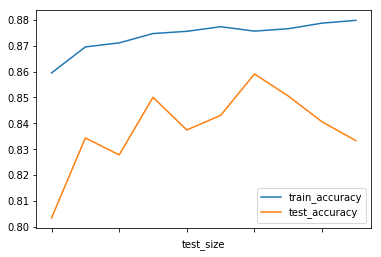

In [162]:
# iterate over test sizes and plot accuracy to demonstrate overfitting
result_dict = {'test_size' :[], 'train_accuracy' : [], 'test_accuracy' : []}
for denom in range(2,12):
    size = 1 / denom
    result_dict['test_size'].append(str(size))
    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(df['raw_text'], df['label'], test_size = size)
    X_train_tmp = vectorizer.transform(X_train_tmp)
    X_test_tmp = vectorizer.transform(X_test_tmp)
    lr_tmp = LogisticRegression(solver = 'lbfgs')
    lr_tmp.fit(X_train_tmp, y_train_tmp)
    y_pred_tmp = lr_tmp.predict(X_test_tmp)
    result_dict['train_accuracy'].append(lr_tmp.score(X_train_tmp, y_train_tmp))
    result_dict['test_accuracy'].append(accuracy_score(y_test_tmp, y_pred_tmp))
result_df = pd.DataFrame(result_dict)
result_df.set_index('test_size', inplace = True)
_ = result_df.plot()

Finally, an ROC (Receiver Operating Characteristic) curve, is perhaps a more informative visualization of the predictor we have build as it considers the False positive and True positive rates. Therefore, it is at least providing more information than an accuracy score which only informs us how many samples were correctly ID'ed. 

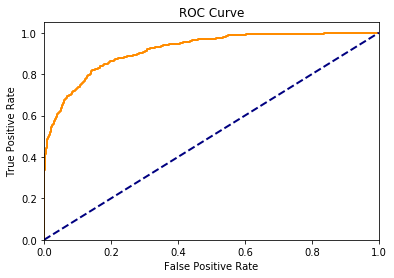

In [166]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_score = lr.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')